In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic-extended:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F122398%2F315766%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240913%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240913T065709Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9a21156919df43a5c70d49bf23229b591fe04d2abe8f6c82b228a09e3c9cc67fd74f347d804e8d11cfd66a1b6b403058971b55a8f3d680e2d12b82391220059ffdcdf05f96e0df251c2f7479a1e6c101add75633ff7c92bcb50e02663f7c8660b5c05204dcb69f35be8a64f2171ad45f58cf39953e49556fa97a8224a462bec369cb9e3e2e132f5df928fd89e0df5abde5580708d096d8a6e14bfb237a94c58abb349bf9cd3eefec627335e6fee0d6c728937751586bc6f1f8a39ece16b676e5500a4e499dc562b84ce7e3cd5ea20ee264146be3fae4bebf569e661084a1741173b197e7ba7c8373b70eb413de3c6df6a1d9a289102de36071b43b680a9cd0d9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 137471 bytes downloaded
Downloaded and uncompressed: titanic-extended
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-extended/train.csv
/kaggle/input/titanic-extended/full.csv
/kaggle/input/titanic-extended/test.csv


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score


In [ ]:
base_path="/kaggle/input/titanic-extended/"
# Load the Titanic dataset (assuming it's downloaded from Kaggle and in the working directory)
titanic_data = pd.read_csv(base_path+"train.csv")

# Display the first few rows of the dataset
print(titanic_data.head())

# Drop irrelevant columns that are not useful for modeling
# We drop columns that are unlikely to influence survival or have many missing values
columns_to_drop = [
    'PassengerId', 'Name', 'Ticket', 'Cabin', 'WikiId', 'Name_wiki',
    'Age_wiki', 'Hometown', 'Boarded', 'Destination', 'Lifeboat', 'Body', 'Class'
]
titanic_data = titanic_data.drop(columns=columns_to_drop, axis=1)

# Fill missing values in 'Age' with the median
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)

# Fill missing values in 'Fare' with the median
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace=True)

# Fill missing values in 'Embarked' with the mode
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

# Encode 'Sex' column as binary: male = 1, female = 0
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 1, 'female': 0})

# Encode 'Embarked' column using Label Encoding
label_encoder = LabelEncoder()
titanic_data['Embarked'] = label_encoder.fit_transform(titanic_data['Embarked'])

# Display the data types and missing values to confirm preprocessing
print(titanic_data.info())

# Split dataset into features and target variable
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve the performance of the model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare  ... Embarked WikiId  \
0      0         A/5 21171   7.2500  ...        S  691.0   
1      0          PC 17599  71.2833  ...        C   90.0   
2      0  STON/O2. 3101282   7.9250  ...        S  865.0   
3      0            113803  53.1000  ...        S  127.0   
4      0            

In [ ]:
class LMSClassifier:
    def __init__(self, learning_rate=0.01, n_iters=1000, clip_value=1.0):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.convergence_history = []
        self.clip_value = clip_value  # Added clip value for gradient clipping

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Training loop
        for _ in range(self.n_iters):
            y_pred = self._predict(X)
            errors = y - y_pred

            # Compute gradients
            grad_weights = np.dot(X.T, errors)
            grad_bias = np.sum(errors)

            # Apply gradient clipping to avoid overflow
            grad_weights = np.clip(grad_weights, -self.clip_value, self.clip_value)
            grad_bias = np.clip(grad_bias, -self.clip_value, self.clip_value)

            # Update weights and bias
            self.weights += self.learning_rate * grad_weights
            self.bias += self.learning_rate * grad_bias

            # Record the mean squared error for convergence analysis
            loss = np.mean(errors ** 2)
            self.convergence_history.append(loss)

            # Check if the loss is NaN or inf to stop training early
            if np.isnan(loss) or np.isinf(loss):
                print("Training stopped due to divergence.")
                break

    def _predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        linear_output = self._predict(X)
        return np.where(linear_output >= 0.5, 1, 0)  # Convert to binary classification


Learning Rate: 0.001, Accuracy: 0.6592
Learning Rate: 0.005, Accuracy: 0.7933
Learning Rate: 0.01, Accuracy: 0.7933
Learning Rate: 0.1, Accuracy: 0.7877
Learning Rate: 0.5, Accuracy: 0.8045


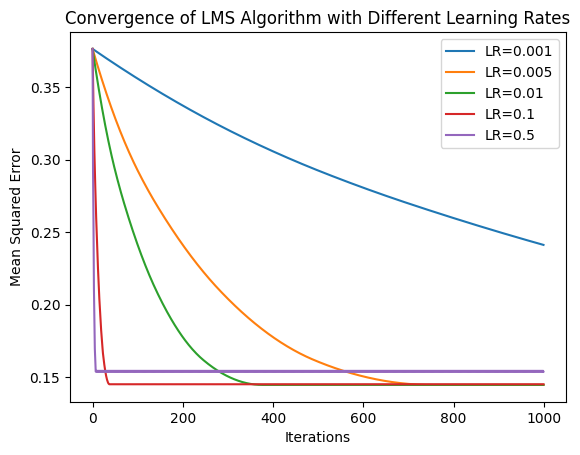

In [ ]:
# Define learning rates to test
learning_rates = [0.001, 0.005, 0.01,0.1,0.5]  # Adjusted learning rates

# Track results for each learning rate
results = {}

# Train and evaluate the model for each learning rate
for lr in learning_rates:
    model = LMSClassifier(learning_rate=lr, n_iters=1000, clip_value=0.1)  # Set clip_value to 0.1 for stability
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[lr] = accuracy
    print(f"Learning Rate: {lr}, Accuracy: {accuracy:.4f}")

    # Plot convergence history
    plt.plot(model.convergence_history, label=f'LR={lr}')

plt.title('Convergence of LMS Algorithm with Different Learning Rates')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
